In [1]:
import numpy as np
import seaborn as sns
from pyfferaph import pyfferaph as pf
from pyfferaph import filter_pyff as pyff 
import MDAnalysis as mda
import pandas as pd
import multiprocessing

# The user has to modify the cell below

All the input files and selection are specifies using dictionaries 

**data_dict** contains the trajctory and topology files 

**analysis_dict** contains the selection of the N residues for which the interaction networks (N x N matrices) will be computed, the stride used to read the trajectory file and the starting and ending frame to be analysed 

**salt_dict** contains the selection for the salt bridge interactions, the default distance is set to 4.5 A and the output name for the interaction file 

**hc_dict** contains the selection for the hydrophbic interactions, the default distance is set to 5 A and the output name for the interaction file 

**hb_dict** contains the selection for the hydrogen bonds, the default distance is set to 3.5 A, the Donor-H-Acceptor angle to 120° and the output name for the interaction file. Since this function can run on more than one core the number of cores is specified here, 0 means that pyfferaph will make use of all the available cores

In [2]:
# Input
data_dict = dict(pdb='example_trajs/sim.prot.A.pdb',
                 traj='example_trajs/traj.xtc',
                 top='example_trajs/sim_protA.tpr'
                 )

# Analysis dict:

# Common data: the argument `system` is required to create the proper
# matrix. Use "protein or resname DGPS" if you want include DGPS lipids
analysis_dict = dict(system="protein",
                     start = 0,
                     stop = None, 
                     stride = 1
                    )

# Salt bridge selection. To include lipids, modify `sel_basic` and `sel_acidic` accordingly.
sb_dict = dict(sb_file="example_matrices/my_sb.dat",
               sel_basic="(resname LYS and name CE NZ HZ*) or (resname ARG and name CD NE CZ NH1 NH2 HH11 HH12 HH21 HH22)",
               sel_acidic="(resname ASP and name CG OD1 OD2) or (resname GLU and name CD OE1 OE2)",
               sb_dist=4.5,
               # Define if there are charged cter, nter and protonated his
               cter_sel="(resid 148 and name C OT1 OT2)",
               nter_sel="",
               histidine_sel=""
              )

# The hydrophobic contacts
hc_dict = dict(hc_file="example_matrices/my_hc.dat",
               hydrophobic_sel="resname ALA ILE VAL LEU PHE MET TRP PRO", 
               backbone_sel="name N H HN CA HA C O OT1 OT2 HT2",
               hc_cutoff=5.
)

# Hydrogen bond selections. To include other molecule, modify acceptor and donor selections accordingly
# 
#NB: ncores defines the number of cores to run the hb analysis in parallel, ncores=0 means all the available cores.
hb_dict = dict(hb_file="example_matrices/my_hb.dat",
               tmp_csv="example_matrices/tmp_file_hbonds",
               acceptors="protein and name OH OG OD1 OD2 OG1 O ND1 NE2 OE2 OW SG OE1 OH2 SD",
               donors="protein and name OH OG NE2 OG1 NE N ND1 NZ NH1 NH2 OW ND2 SG OH2 NE1",
               d_a_dist=3.5,
               angle=120,
               update_sel=False,
               ncores=1
)



# Salt bridges 

Computing the salt bridge interaction network and plotting the resulting matrix, 100 means that that specific interaction is observed in every one of the analysed frames

<AxesSubplot:>

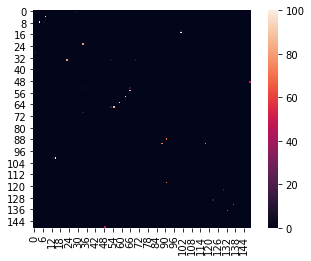

In [3]:
sb = pf.SaltBridges(input_dict=data_dict, 
                   analysis_dict=analysis_dict, 
                   sb_dict=sb_dict)

sb_network = sb.run()

sns.heatmap(sb_network, square=True)

Plotting the size of the biggest sb cluster as a function of increasing p min. The stride can be changed, default is set to 0.1.

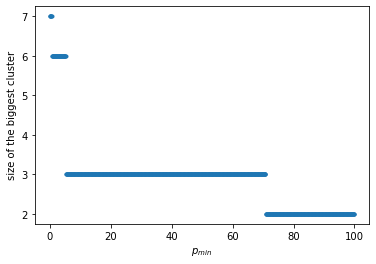

In [4]:
sb_matrix = np.loadtxt("example_matrices/my_sb.dat")
pyff.cluster_plotter(sb_matrix, 'sb_cluster.pdf', stride=0.1)

# Hydrophobic contacts

Computing the hydrophobic interaction network and plotting the resulting matrix, 100 means that that specific interaction is observed in every one of the analysed frames

<AxesSubplot:>

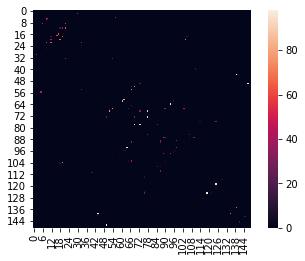

In [5]:
hc = pf.HydrophobicInteractions(input_dict=data_dict, 
                   analysis_dict=analysis_dict, 
                   hc_dict=hc_dict)

hc_network = hc.run()

sns.heatmap(hc_network, square=True)

Plotting the size of the biggest hc cluster as a function of increasing p min. The stride can be changed, default is set to 0.1.

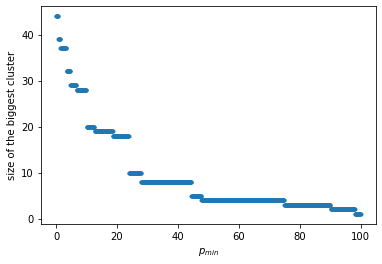

In [6]:
hc_matrix = np.loadtxt("example_matrices/my_hc.dat")
pyff.cluster_plotter(hc_matrix, 'hc_cluster.pdf')

# Hydrogen bonds


Initialsing the hydrogen bonds function 

In [7]:
u = mda.Universe(data_dict['top'], data_dict['traj'], in_memory=True)

# Need to know the number of entry to initialise the matrix
sel = u.select_atoms(analysis_dict['system'])
residxs = np.unique(sel.resindices)
nres = len(residxs)

# Need to know the number of frames to run in parallel
if analysis_dict['stop'] == None:
    nframes = (u.trajectory.n_frames - analysis_dict['start']) // analysis_dict['stride']
else:
    nframes = (analysis_dict['stop'] - analysis_dict['start']) // analysis_dict['stride']


Running HB analysis. This function returns as many csv files (containing the results of the hb analysis) as the number of cores used for the calculation. If only one core is given all the analysis will be run on a single core and only one csv file will be generated, if run on n cores n csv files will be generated.

In [8]:
pf.HBondInteraction(data_dict['top'], data_dict['traj'], 
                 donor_sel=hb_dict['donors'], 
                 acceptor_sel=hb_dict['acceptors'], 
                 nframe=nframes, output_csv=hb_dict['tmp_csv'], ncores=hb_dict['ncores'])

Using 1
THe intervals are: [(0, None)]
Pooling with 1 core(s)...


merging all the csv files generated in the previous step

In [9]:
merged_df = pf.MergingHBDataframe(hb_dict['tmp_csv'], nframe=nframes, ncores=hb_dict['ncores'])

Using 1


generating and plotting the final HB matrix containing the results of HB analysis

In [10]:
pf.HBMatrix(u=u, nres=nres, nframes=nframes, hb_df=merged_df, 
         stride=analysis_dict['stride'], hb_file=hb_dict['hb_file'])

<AxesSubplot:>

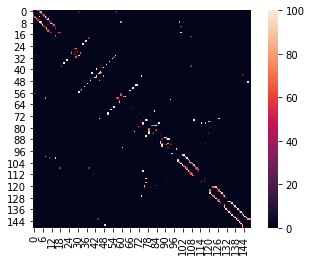

In [11]:
hb_matrix = np.loadtxt(hb_dict['hb_file'])
sns.heatmap(hb_matrix, square=True)

Plotting the size of the biggest hb cluster as a function of increasing p min. The stride can be changed, default is set to 0.1.

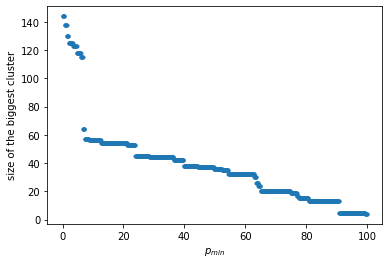

In [12]:
pyff.cluster_plotter(hb_matrix, 'hb_cluster.pdf')

# PSN

Generating the final Interaction Network merging together the sb, hc and hb matrix generated in the previous steps. The threshold for filtering is the same used by the authors of Pyinteraph for the example analysis

In [13]:
macro_inn = pyff.macroINN_generator([hc_matrix, sb_matrix, hb_matrix], 20)

final_network = pyff.network_generator(macro_inn, 'example_trajs/sim.prot.A.pdb')

print(final_network.nodes)

['SER2', 'ARG3', 'ALA4', 'LYS5', 'ARG6', 'ILE7', 'MET8', 'LYS9', 'GLU10', 'ILE11', 'GLN12', 'ALA13', 'VAL14', 'LYS15', 'ASP16', 'ASP17', 'PRO18', 'ALA19', 'ALA20', 'HIS21', 'ILE22', 'THR23', 'LEU24', 'GLU25', 'PHE26', 'VAL27', 'SER28', 'GLU29', 'SER30', 'ASP31', 'ILE32', 'HIS33', 'HIS34', 'LEU35', 'LYS36', 'GLY37', 'THR38', 'PHE39', 'LEU40', 'GLY41', 'PRO42', 'PRO43', 'GLY44', 'THR45', 'PRO46', 'TYR47', 'GLU48', 'GLY49', 'GLY50', 'LYS51', 'PHE52', 'VAL53', 'VAL54', 'ASP55', 'ILE56', 'GLU57', 'VAL58', 'PRO59', 'MET60', 'GLU61', 'TYR62', 'PRO63', 'PHE64', 'LYS65', 'PRO66', 'PRO67', 'LYS68', 'MET69', 'GLN70', 'PHE71', 'ASP72', 'THR73', 'LYS74', 'VAL75', 'TYR76', 'HIS77', 'PRO78', 'ASN79', 'ILE80', 'SER81', 'SER82', 'VAL83', 'THR84', 'GLY85', 'ALA86', 'ILE87', 'CYS88', 'LEU89', 'ASP90', 'ILE91', 'LEU92', 'LYS93', 'ASN94', 'ALA95', 'TRP96', 'SER97', 'PRO98', 'VAL99', 'ILE100', 'THR101', 'LEU102', 'LYS103', 'SER104', 'ALA105', 'LEU106', 'ILE107', 'SER108', 'LEU109', 'GLN110', 'ALA111', 'LEU1

/Users/alberto/miniconda3/envs/pyffe/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:330: UserWarning: Element information is absent or missing for a few atoms. Elements attributes will not be populated.
  warnings.warn("Element information is absent or missing for a few "


Example for all_shortest_path. This function prints to file all shortest paths in netework final_network connecting SER2 and SER150. A score is assigned to each path; the score is computed summing the frequencies, calculated over all the paths connecting source and target, of each residue in the path;
all_shortest_path returns the communication robustness (cr) index for the pathway source-target (s-t) as:

    cr(s-t) = (paths s-t) * treshold / lenght_shortest_path 

In [14]:
pyff.all_shortest_path(final_network, 'SER2',  'SER150', 20, terminal=True)

['SER2', 'ARG6', 'GLU10', 'LEU102', 'ALA105', 'LEU109', 'LEU112', 'HIS77', 'ILE80', 'VAL75', 'PHE52', 'ALA149', 'LYS51', 'SER150'] 	score= 52
['SER2', 'ARG6', 'GLU10', 'LEU102', 'LEU106', 'LEU109', 'LEU112', 'HIS77', 'ILE80', 'VAL75', 'PHE52', 'ALA149', 'LYS51', 'SER150'] 	score= 52
['SER2', 'ARG6', 'GLU10', 'LEU102', 'ALA105', 'LEU109', 'LEU112', 'HIS77', 'ILE80', 'VAL75', 'PHE52', 'ALA149', 'THR145', 'SER150'] 	score= 52
['SER2', 'ARG6', 'GLU10', 'LEU102', 'LEU106', 'LEU109', 'LEU112', 'HIS77', 'ILE80', 'VAL75', 'PHE52', 'ALA149', 'THR145', 'SER150'] 	score= 52
Number of shortest paths: 4
Length of the shortest path: 14
CR index = 0.06
Best shortest path:
['SER2', 'ARG6', 'GLU10', 'LEU102', 'ALA105', 'LEU109', 'LEU112', 'HIS77', 'ILE80', 'VAL75', 'PHE52', 'ALA149', 'LYS51', 'SER150']
['SER2', 'ARG6', 'GLU10', 'LEU102', 'LEU106', 'LEU109', 'LEU112', 'HIS77', 'ILE80', 'VAL75', 'PHE52', 'ALA149', 'LYS51', 'SER150']
['SER2', 'ARG6', 'GLU10', 'LEU102', 'ALA105', 'LEU109', 'LEU112', 'HIS77

([['SER2',
   'ARG6',
   'GLU10',
   'LEU102',
   'ALA105',
   'LEU109',
   'LEU112',
   'HIS77',
   'ILE80',
   'VAL75',
   'PHE52',
   'ALA149',
   'LYS51',
   'SER150'],
  ['SER2',
   'ARG6',
   'GLU10',
   'LEU102',
   'LEU106',
   'LEU109',
   'LEU112',
   'HIS77',
   'ILE80',
   'VAL75',
   'PHE52',
   'ALA149',
   'LYS51',
   'SER150'],
  ['SER2',
   'ARG6',
   'GLU10',
   'LEU102',
   'ALA105',
   'LEU109',
   'LEU112',
   'HIS77',
   'ILE80',
   'VAL75',
   'PHE52',
   'ALA149',
   'THR145',
   'SER150'],
  ['SER2',
   'ARG6',
   'GLU10',
   'LEU102',
   'LEU106',
   'LEU109',
   'LEU112',
   'HIS77',
   'ILE80',
   'VAL75',
   'PHE52',
   'ALA149',
   'THR145',
   'SER150']],
 0.06)

Computes the selective betweenness for a specific residue

In [21]:
pyff.selective_betweenness(final_network, source='SER2',  target='SER150', sb_residue='SER2')

source: SER2 target: SER150
selective betweenness for SER2: 1.0


1.0

Suitable function for getting all shortest path and corrisponding cr index for each pair of residues in the two input lists. Convenient for studying connection of interfaces residues.

In [23]:
pyff.paths_to_interface(final_network, interface_residues=['SER2', 'ALA105'],  source_residues=['SER150', 'ALA149'], threshold=20)

6 paths written to SER2.dat
3 paths written to ALA105.dat
